<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy


## Alumno: Fux, Santiago Javier (CEIA-6ta Cohorte)
### Fecha: 2023-03-15

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [3]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

In [7]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [8]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2023-03-15 16:40:59 INFO: Downloading default packages for language: es (Spanish)...


2023-03-15 16:53:53 INFO: Finished downloading models and saved to /home/santiago/stanza_resources.
2023-03-15 16:53:53 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2023-03-15 16:53:53 INFO: Use device: cpu
2023-03-15 16:53:53 INFO: Loading: tokenize
2023-03-15 16:53:54 INFO: Loading: mwt
2023-03-15 16:53:54 INFO: Loading: pos
2023-03-15 16:53:54 INFO: Loading: lemma
2023-03-15 16:53:54 INFO: Loading: depparse
2023-03-15 16:53:54 INFO: Loading: ner
2023-03-15 16:53:55 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [10]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [33]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?", "Hola, ¿Cómo podemos ayudarte?"],
             },
             {"tag": "precio",
              "patterns": ["precio", "¿Cúal es el precio?", "¿Cuánto cuesta?", "¿Qué precio tiene?", "¿Cuánto vale?", "¿Cuánto sale?"],
              "responses": ["El precio del controlador es de $62.000 + IVA"]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Podés escribirnos por mail a soporte@device.com", "Nuestro correo es soporte@device.com, esperamos tu mail!"]
             },
            {"tag": "envios",
              "patterns": ["¿Realizan envios?", "¿Cómo me llega el paquete?"],
              "responses": ["Hacemos envíos por Vía Cargo a toda Argentina. Y por DHL al exterior."]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas", "transferencia", "mercado pago"],
              "responses": ["Aceptamos pagos por transferencia bancaria y Mercado Pago. En este link (https://google.com) podés encontrar los datos."]
             },
            {"tag": "stock",
              "patterns": ["Esto está disponible", "¿Tenes stock?", "¿Hay stock hoy?"],
              "responses": ["Sí, tenemos stock para envío inmediato."]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             },
            {"tag": "conexion wifi",
              "patterns": [ "No puedo conectarme por Wifi", "no puedo conectarme a internet", "problema conexión wifi"],
              "responses": ["Por favor, verifica que la red sea 2.4GHz", "Recordá que primero tenés que asociar al equipo a tu cuenta",
              "Verificá que el led de comunicación parpadee en color azul."]
            },
            {"tag": "conexion bluetooth",
              "patterns": [ "No puedo conectarme localmente", "no puedo conectarme por bluetooth", "No puedo acceder directo a el equipo"],
              "responses": ["Por favor, verifica que el equipo esté encendido y no haya otro dispositivo móvil conectado.", 
                "Verificá los permismos de la aplicación. Al inicio te solicitará permiso para conectarte y tenés que aceptarlo.",
              ]
            },
            {"tag": "informacion",
              "patterns": [ "Hola quiero recibir más información", "Pueden enviarme documentos técnicos?", "Quiero conocer más sobre el equipo"],
              "responses": ["Hola, en la sección de soporte de nuestra web podrás obtener más información: https://google.com/soporte", 
                "Accedé a más información sobre nuestro producto en https://google.com/soporte",
              ]
            },
            {"tag": "sensores",
              "patterns": [ "Puedo conectar sensores?", "Qué sensores puedo instalar?", "Cuantos sensores puedo conectar?"],
              "responses": ["Es posible conectar hasta 6 sensores analógicos y digitales. Los sensores pueden ser de humedad, caudal, ph, etc.",
              ]
            },
            {"tag": "valvulas",
              "patterns": [ "Cuántas válvulas puedo conectar?", "Cuántas zonas tiene?", "Puedo conectar una bomba?"],
              "responses": ["Si, podés conectar hasta 8 zonas de riego y 2 bombas. Contás con hasta 8 programas con diferentes modos de activación.",
              ]
            },
            
]}

### 4 - Preprocesamiento y armado del dataset

In [34]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [35]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'acceder', 'bluetooth', 'bomba', 'chau', 'como', 'conectar', 'conexion', 'conocer', 'contacto', 'costar', 'credito', 'cual', 'cuanto', 'cuota', 'de', 'directo', 'disponible', 'documento', 'el', 'enviar', 'envio', 'equipo', 'este', 'gracias', 'haber', 'hasta', 'holar', 'hoy', 'informacion', 'instalar', 'internet', 'llegar', 'localmente', 'luego', 'mas', 'medio', 'mercado', 'mucho', 'no', 'numero', 'pago', 'paquete', 'poder', 'por', 'precio', 'problema', 'que', 'querer', 'realizar', 'recibir', 'salir', 'sensor', 'ser', 'sobre', 'stock', 'tal', 'tarjeta', 'tecnico', 'telefono', 'tener', 'transferencia', 'uno', 'valer', 'valvula', 'whatsapp', 'wifi', 'yo', 'zona']
classes: ['agradecimientos', 'bienvenida', 'conexion bluetooth', 'conexion wifi', 'contacto', 'despedida', 'envios', 'informacion', 'pagos', 'precio', 'sensores', 'stock', 'valvulas']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', 'precio', '¿Cúal es el precio?', '¿Cuánto cuesta?', '¿Qué precio tiene?', '¿Cuánto vale?'

In [36]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 69


In [37]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 13


In [38]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0,

### 5 - Entrenamiento del modelo

In [39]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (69,) output: 13


In [40]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               8960      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 13)                845       
                                                                 
Total params: 18,061
Trainable params: 18,061
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 0s 2ms/step - loss: 2.5818 - accuracy: 0.1364
Epoch 2/200
2/2 [==============================] - 0s 2ms/step - loss: 2.5883 - accuracy: 0.0909
Epoch 3/200
2/2 [==============================] - 0s 2ms/step - loss: 2.5558 - accuracy: 0.0455
Epoch 4/200
2/2 [==============================] - 0s 3ms/step - loss: 2.5467 - accuracy: 0.1364
Epoch 5/200
2/2 [==============================] - 0s 3ms/step - loss: 2.5019 - accuracy: 0.1818
Epoch 6/200
2/2 [==============================] - 0s 3ms/step - loss: 2.5239 - accuracy: 0.1136
Epoch 7/200
2/2 [==============================] - 0s 2ms/step - loss: 2.5149 - accuracy: 0.2045
Epoch 8/200
2/2 [==============================] - 0s 3ms/step - loss: 2.5033 - accuracy: 0.0909
Epoch 9/200
2/2 [==============================] - 0s 3ms/step - loss: 2.5010 - accuracy: 0.1818
Epoch 10/200
2/2 [==============================] - 0s 3ms/step - loss: 2.4651 - accuracy: 0.2500
Epoch 11/200
2/2 [===========

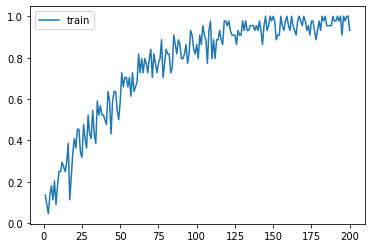

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [43]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [45]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [55]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Q: hola!
BOT: Hola, ¿Cómo estás?
Q: cuanto vale el equipo?
BOT: El precio del controlador es de $62.000 + IVA
Q: quiero obtener más información
BOT: Hola, en la sección de soporte de nuestra web podrás obtener más información: https://google.com/soporte
Q: puedo conectar una bomba?
BOT: Si, podés conectar hasta 8 zonas de riego y 2 bombas. Contás con hasta 8 programas con diferentes modos de activación.
Q: cuantos sensores puedo conectar?
BOT: Es posible conectar hasta 6 sensores analógicos y digitales. Los sensores pueden ser de humedad, caudal, ph, etc.
Q: hacen envios?
BOT: Hacemos envíos por Vía Cargo a toda Argentina. Y por DHL al exterior.
Q: no puedo conectarme a Internet
BOT: Verificá que el led de comunicación parpadee en color azul.
Q: tampoco puedo conectarme localmente
BOT: Verificá los permismos de la aplicación. Al inicio te solicitará permiso para conectarte y tenés que aceptarlo.
Q: gracias!
BOT: Por nada!, cualquier otra consulta podes escribirme
Q: 
BOT: Perdón, no co

KeyboardInterrupt: Interrupted by user

### 7 - Conclusiones
Existe un problema en el algoritmo al intentar utilizar palabras como "al" o "del" porque al lematiar se expanden de 1 a 2 tokens.
El entrenamiento demestra haber convergido a un punto de accuracy muy alto y se refleja en el chat de ejemplo más arriba.